In [1]:
NOTE = 'SVM(C=1.0)連続量はPCA-cv=pitcherID'
notebook_name = '092'
CV = 'GroupK-Fold(pitcherID)'
group_col = 'pitcherID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

092_submission.csv 092


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])
train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(1857, 384, 107)

In [7]:
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [120,
  478,
  504,
  607,
  587,
  107,
  136,
  447,
  363,
  2,
  618,
  593,
  616,
  597,
  407,
  48,
  58,
  4,
  394,
  49],
 '1': [311,
  305,
  269,
  143,
  224,
  182,
  267,
  55,
  156,
  550,
  371,
  336,
  575,
  158,
  400,
  211,
  647,
  222,
  493,
  528],
 '2': [130,
  651,
  298,
  448,
  387,
  405,
  634,
  438,
  102,
  245,
  507,
  190,
  147,
  520,
  169,
  210,
  409,
  595,
  494,
  630],
 '3': [247,
  128,
  282,
  185,
  657,
  288,
  459,
  45,
  419,
  16,
  434,
  579,
  596,
  435,
  81,
  334,
  181,
  6,
  467,
  635],
 '4': [348,
  373,
  191,
  101,
  116,
  59,
  383,
  517,
  506,
  350,
  376,
  460,
  35,
  97,
  650,
  119,
  662,
  10,
  359],
 '5': [542,
  241,
  155,
  218,
  196,
  82,
  532,
  524,
  31,
  294,
  110,
  578,
  137,
  476,
  358,
  552,
  262,
  553],
 '6': [483,
  519,
  377,
  395,
  481,
  -1,
  146,
  563,
  29,
  25,
  539,
  114,
  522,
  501,
  474,
  440,
  351,
  275],
 '7': [629,
  365,
  640,
  623,
  

In [17]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    ## descrete features
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler()),
            ('decomposer', PCA(n_components=0.9, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[discrete_features])
    new_columns = [f'pca{i + 1}' for i in range(discrete_transformer[-1].n_components_)]
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=new_columns,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=new_columns,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=new_columns,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = new_columns
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = pd.concat([X_train_categorical,
                                     X_train_discrete,
#                                      X_train_vector
                                    ],
                                    axis=1)
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = pd.concat([X_valid_categorical,
                                     X_valid_discrete,
#                                      X_valid_vector
                                    ],
                                    axis=1)
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = pd.concat([X_test_categorical,
                                    X_test_discrete,
#                                     X_test_vector
                                   ],
                                   axis=1)
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    # classification    
    clf = SVC(random_state=SEED, C=1.0, class_weight='balanced')
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print(f'score: {f1_score(y_train, pred_train, average="macro")}')
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print(f'score: {f1_score(y_valid, pred_valid, average="macro")}')
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


**********Confusion matrix for train set (Fold 1)**********
[[1796 1350  602  627  723  343   19  218]
 [ 580 2024  382  402  426  202   14  130]
 [ 350  518  763  401  384  140    8   92]
 [ 228  353  237  800  204   55    3   25]
 [  32   40   21   16  485   13    0    6]
 [   0    0    0    0    0  172    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  104]]
score: 0.3601674811491473

**********Confusion matrix for validation set (Fold 1)**********
[[197 204  50  84  96  15   0   9]
 [117 233  46  47  51  17   0  11]
 [ 70  72  63  69  51   3   0   8]
 [ 49  51  22  60  41   4   0   4]
 [ 14  15   4  18   9   1   0   1]
 [  4   2   4   4   1   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  2   5   0   3   4   0   0   2]]
score: 0.1731886051306193

**********Confusion matrix for train set (Fold 2)**********
[[1749 1301  584  642  687  339   17  234]
 [ 584 1981  364  390  422  210   15  141]
 [ 346  498  765  402  370  138    8  100]
 [ 212

In [18]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.364685,0.163614
std,0.003297,0.009600
min,0.360167,0.146922
25%,0.362753,0.156522
50%,0.363760,0.166854
75%,0.367635,0.170142
max,0.369597,0.175208


In [19]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17075,1431,1,1,1,10
17076,1432,0,4,1,10
17077,1433,1,3,1,10
17078,1434,2,4,1,10


In [20]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,2.860164,5.266624,6.267613,4.219911,7.284037,0.716216,-0.288175,1.751310,27446,1
1,5.247609,4.231336,7.282639,6.275461,2.950855,0.721925,-0.292375,1.747024,113,1
2,6.285276,7.288876,5.272994,4.230002,2.800033,0.712619,-0.293242,1.731816,4479,1
3,5.278823,7.284445,6.281150,4.260203,2.813836,0.708258,-0.295853,1.737496,29080,1
4,7.273670,5.260219,5.256287,5.248610,3.208582,1.747052,-0.298081,0.727535,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,5.257956,7.301953,6.266128,4.243033,3.255663,1.749540,-0.291114,0.690358,24272,10
33804,2.788989,1.701945,6.294370,5.296223,7.297748,4.218405,-0.294310,0.703340,29106,10
33805,2.737979,1.707180,7.299079,6.296846,5.290981,4.142002,-0.299302,0.724311,20679,10
33806,7.305561,2.710896,5.282172,4.272311,6.285983,1.727355,-0.294642,0.702220,25901,10


In [21]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,44.339529,73.004418,61.719748,51.585173,31.496812,17.732385,-3.007784,6.998298
1,1,62.834847,72.911918,52.575460,42.417900,17.358756,30.280562,-3.010319,7.169756
2,2,12.468058,29.433106,54.515228,45.426210,67.813311,15.341770,-2.973537,59.020836
3,3,53.563568,72.907201,33.021520,51.639286,51.461694,17.428569,-2.990134,7.114594
4,4,62.935007,72.999750,34.127771,40.423407,50.268640,14.124022,-2.990826,10.140062
...,...,...,...,...,...,...,...,...,...
33803,33803,70.881449,33.514861,39.798348,53.151766,63.609161,17.437431,-2.986416,8.322968
33804,33804,68.901002,61.845236,41.986191,57.813646,28.364224,8.188731,-3.051263,17.582175
33805,33805,72.865958,62.740844,20.788054,52.183830,30.804466,9.577337,-2.874172,32.762710
33806,33806,38.418123,61.668916,49.579278,72.827933,40.293732,19.538989,-2.984094,6.997875


In [22]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,0
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.222166
1    0.406087
2    0.073622
3    0.144226
4    0.131300
5    0.014760
6    0.000355
7    0.007483
Name: y, dtype: float64

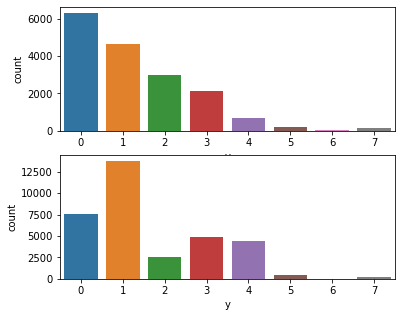

In [23]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [24]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [25]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.3646851813934067, 0.1636142591418966)

In [26]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"092_submission.csv","GroupK-Fold(pitcherID)","0.364685","0.163614","","SVM(C=1.0)連続量はPCA-cv=pitcherID"


In [27]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [28]:
imp_df

""


In [29]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [30]:
coef_df

""
